# Transformer 

In this notebook we will present the Transformer Regressor with MultiHead Attention. These models use PyTorch's Embedding class, which has trainable embeddings, so we will not use any vectorization technique.

### Implementation in Python

Let's begin by importing the libraries we need.

In [10]:
# Data handling
import numpy as np
import pandas as pd
import math

import multiprocessing

import torch
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

In order to use GPU for training, we use the following cell.

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


### Loading the dataset

We load our dataset and add empty texts in case of missing values.

In [12]:
df = pd.read_csv("../../DATASETS/preprocessed_text.csv")

In [13]:
df.isnull().sum()
df.fillna('', inplace=True)
df.head()

,content,score,content_cleaned
0,Plsssss stoppppp giving screen limit like when...,2,plss stopp giving screen limit like when you a...
1,Good,5,good
2,👍👍,5,thumbs_up
3,Good,3,good
4,"App is useful to certain phone brand ,,,,it is...",1,app is useful to certain phone brand it is not...


### Tokenizing and padding

First we need to tokenize our sequences and turn them into integers. For this we will use the keras Tokenizer function from Tensorflow.

The next step is to pad the sequences so all of them are of the same size. This is done because in RNNs, the model has a set input size. Therefore, in order all the input sequences to have the same size, we introduce zero padding at the end of each sequence. For this we will use the pad_sequences function from Tensorflow.

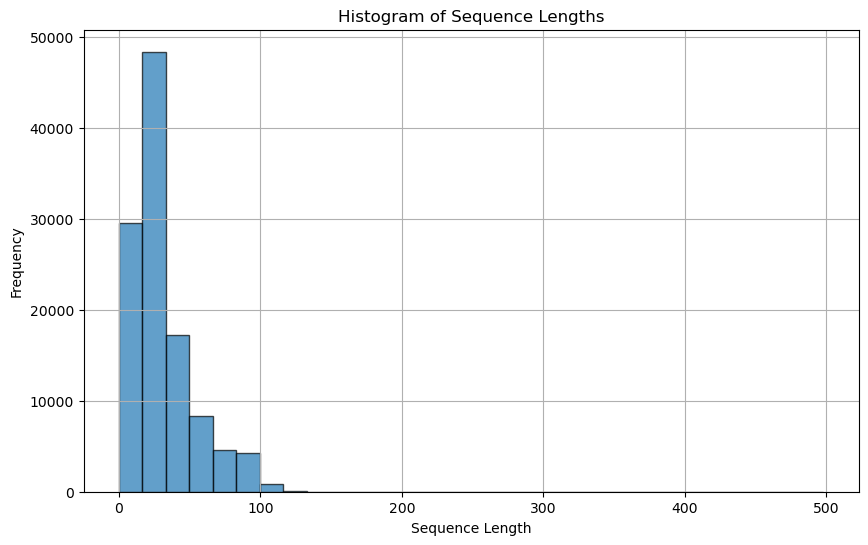

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Step 1: Initialize and fit the tokenizer
tokenizer = Tokenizer(num_words=40000, oov_token="<OOV>")  # Limit vocab size to 40000 and add an out-of-vocabulary token

tokenizer.fit_on_texts(df['content_cleaned'].values)

# Step 2: Convert texts to sequences of integers
sequences = tokenizer.texts_to_sequences(df['content_cleaned'].values)

sequence_lengths = [len(sequence) for sequence in sequences]

# Plot histogram of sequence lengths
plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Histogram of Sequence Lengths')
plt.grid(True)
plt.show()

In [15]:
import joblib

joblib.dump(tokenizer, 'tokenizer.pkl')

['tokenizer.pkl']

We notice that the majority of sequences are until size 140. So we will pad all our sequences to size 140.

In [16]:
# Step 3: Pad sequences

MAX_SEQUENCE_LENGTH = 140

padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

### Vectorization

In RNN, we do not have to vectorize our data. The deep networks usually have an Embedding input layer, which is learnable and it turns our tokenized padded inputs into embeddings.

### Preparing the dataset

PyTorch wants all the inputs and labels to be turned into tensors in order to be used in networks.

In [17]:
# Turn inputs into tensors
padded_reviews = torch.tensor(padded_sequences, dtype=torch.long)

### Preparing the labels 

We scale the labels into the range 1 to 5 with MinMaxScaler. They are already in that range but we fit our scaler to be able to use it on new unseen data.

In [18]:
y_df = df[['score']]

y_scaler = MinMaxScaler(feature_range=(1, 5))
y = y_scaler.fit_transform(y_df)

# Turn labels into tensors
y = torch.tensor(y, dtype=torch.float)  # Labels

### Train - test split

We perform the train-test split, keeping 20% of the original data for evaluation. We also keep the indices split of our dataframe.

In [19]:
indices = df.index

train_reviews, test_reviews, y_train, y_test, train_idx, test_idx = train_test_split(padded_reviews, y.flatten(), indices, test_size=0.2, random_state=42)

### Dataset and Dataloader classes

After the data have been turned into tensors and the train-test split is performed, they have to be loaded in the Dataset and Dataloader classes.

The first creates dataset instances, grouping input-output pairs of data together. This is needed, since the Dataloader class only accepts Dataset objects.

The Dataloader takes Dataset instances and shuffles the contents and puts them into batches.

In [20]:
# Define Custom Dataset Class
class ReviewsDataset(Dataset):
    def __init__(self, reviews, labels):
        self.reviews = reviews
        self.labels = labels

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        return self.reviews[idx], self.labels[idx]

In [21]:
# Create Train and Test Dataset Instances
train_dataset = ReviewsDataset(train_reviews, y_train)
test_dataset = ReviewsDataset(test_reviews, y_test)

In [22]:
# Set the batch size
batch_size = 32

# DataLoader for training set
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# DataLoader for testing set (usually no shuffling)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Model

Next we define our Transformer model. Firstly, we define the Embedding layer, according to the transformer architecture. Ti consists of two different layers, one input embedding and one positional embedding layer. The input embedding layer is a trainable layer that turns the inputs into embeddings. The positional embeddings are not learnable and they encode the position of the tokens using two functions, one sin and one cosin. The two embeddings are then added and are passed through a dropout layer before being fed further into the model.

In [23]:
class Embedding(nn.Module):
    def __init__(self,vocab_size,d_model=50,dropout=0.1,max_len=500):
        super().__init__()
        self.d_model = d_model
        self.input_embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        pe = self.pos_encoding(max_len, d_model)
        self.pos_embedding = nn.Embedding.from_pretrained(pe, freeze=True)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, X):
        pos_mat = torch.arange(X.size(dim=-1)).to(device)
        X = self.input_embedding(X) * math.sqrt(self.d_model)
        X += self.pos_embedding(pos_mat)
        return self.dropout(X)

    def pos_encoding(self, max_len, d_model):
        dividend = torch.arange(max_len).unsqueeze(0).T
        divisor = torch.pow(10000.0, torch.arange(0, d_model, 2)/d_model)
        epsilon = 1e-8
        angles = dividend / (divisor+epsilon)
        pe = torch.zeros((max_len, d_model))
        pe[:, 0::2] = torch.sin(angles)
        pe[:, 1::2] = torch.cos(angles)
        return pe

vocab_size = 39783
embedding = Embedding(vocab_size).to(device)

Then we define the Transformer architecture. After the embedding layer come several tranformer encoder layers. During the forward pass, we also take into account the padding tokens with a padding mask. This helps the model not include the padding tokens in the attention operations. The encoder is followed by averaging all the embeddings into one and passing it through a Linear layer with 1 output channel, since this is a regression task. 

In [24]:
class Model(nn.Module):
    def __init__(self,embeddings,nhead,num_layers,nbr_classes,d_model=50,dim_feedforward=2048,dropout=0.1):
        super().__init__()
        self.embeddings = embeddings
        self.encoder_layer = nn.TransformerEncoderLayer(d_model,nhead,batch_first=True,dropout=dropout,dim_feedforward=dim_feedforward, activation='gelu')
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers)
        self.fc = nn.Linear(d_model, nbr_classes)
        
    def forward(self, X):
        padding_mask = (X == 0)
        X = self.embeddings(X)
        X = self.encoder(X, src_key_padding_mask=padding_mask)
        X = torch.mean(X, dim=1)
        return self.fc(X)

In [25]:
# Hyperparameters
nhead = 5
num_layers = 5  # number of LSTM layers
nbr_classes = 1
learning_rate = 0.0001
num_epochs = 10

Furthermore, we use the MSE loss as loss criterion and Adam as the optimizer for our training.

In [26]:
# Initialize the model, loss function, and optimizer
model = Model(embedding,nhead,num_layers,nbr_classes)
model.to(device)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

C:\Users\geoch\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


After we have defined and initialized the model, we run the training loop

In [27]:
# Training loop
for epoch in range(num_epochs):
    progress_bar = tqdm(train_dataloader)
    model.train()
    epoch_loss = 0.0
    for step, (reviews, labels) in enumerate(progress_bar, 1):
        
        reviews, labels = reviews.to(device), labels.to(device)
            
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(reviews)
        outputs = outputs.squeeze(1)  # Squeeze output to match the ratings shape
        outputs = torch.where(torch.isnan(outputs), torch.zeros_like(outputs), outputs)
        
        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        
        for name, param in model.named_parameters():
            if param.grad is not None and torch.isnan(param.grad).any():
                print(f"NaN detected in gradients of {name}")
        
        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

        epoch_loss += loss.item()

    # Print epoch loss
    avg_loss = epoch_loss / len(train_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')


  0%|                                                                                         | 0/2833 [00:00<?, ?it/s]C:\Users\geoch\anaconda3\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
100%|██████████████████████████████████████████████████████████████████████████████| 2833/2833 [03:04<00:00, 15.32it/s]


Epoch [1/10], Loss: 1.6407


100%|██████████████████████████████████████████████████████████████████████████████| 2833/2833 [01:23<00:00, 33.83it/s]


Epoch [2/10], Loss: 1.2942


100%|██████████████████████████████████████████████████████████████████████████████| 2833/2833 [01:24<00:00, 33.51it/s]


Epoch [3/10], Loss: 1.1973


100%|██████████████████████████████████████████████████████████████████████████████| 2833/2833 [01:24<00:00, 33.55it/s]


Epoch [4/10], Loss: 1.1454


100%|██████████████████████████████████████████████████████████████████████████████| 2833/2833 [01:24<00:00, 33.61it/s]


Epoch [5/10], Loss: 1.1137


100%|██████████████████████████████████████████████████████████████████████████████| 2833/2833 [01:23<00:00, 33.85it/s]


Epoch [6/10], Loss: 1.0834


100%|██████████████████████████████████████████████████████████████████████████████| 2833/2833 [01:24<00:00, 33.52it/s]


Epoch [7/10], Loss: 1.0605


100%|██████████████████████████████████████████████████████████████████████████████| 2833/2833 [01:24<00:00, 33.52it/s]


Epoch [8/10], Loss: 1.0382


100%|██████████████████████████████████████████████████████████████████████████████| 2833/2833 [01:24<00:00, 33.64it/s]


Epoch [9/10], Loss: 1.0240


100%|██████████████████████████████████████████████████████████████████████████████| 2833/2833 [01:24<00:00, 33.54it/s]

Epoch [10/10], Loss: 1.0088


After we train our model, we can make predictions on our test dataset.

In [28]:
model.eval()  # Set the model to evaluation mode

# Test the model on the test dataset
all_preds = []
all_labels = []

with torch.no_grad():
    progress_bar = tqdm(test_dataloader)
    
    for step, (reviews, labels) in enumerate(progress_bar, 1):

        reviews, labels = reviews.to(device), labels.to(device)
        outputs = model(reviews)
        outputs = torch.where(torch.isnan(outputs), torch.zeros_like(outputs), outputs)
        
        # Collect predictions and labels
        all_preds.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all batches to form the complete arrays
y_pred = np.concatenate(all_preds, axis=0)
y_test = np.concatenate(all_labels, axis=0)

100%|███████████████████████████████████████████████████████████████████████████████| 709/709 [00:05<00:00, 120.01it/s]


In [29]:
i=0
if np.any(np.isnan(y_pred)):
    print("NaNs detected in predictions")
    i=i+1
print(i)

0


In [30]:
y_pred

array([[1.2725459],
       [1.0889271],
       [5.129243 ],
       ...,
       [1.3283143],
       [4.1829977],
       [3.930577 ]], dtype=float32)

In order to properly evaluate the predictions, we need to invert the scaling to turn them back in the desired range of values.

In [31]:
# Inverse transform the predictions and actual test values
y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

In [32]:
y_pred

array([1.2725459, 1.0889271, 5.129243 , ..., 1.3283143, 4.1829977,
       3.930577 ], dtype=float32)

In [33]:
y_test

array([1., 1., 5., ..., 1., 1., 4.], dtype=float32)

Moreover, we notice that some values are less than 1 and more than 5, so we clip them in 1-5 range.

In [34]:
# Clip predictions to stay within the 1-5 range
y_pred_original_clipped = np.clip(y_pred, 1, 5)

In [35]:
y_pred_original_clipped

array([1.2725459, 1.0889271, 5.       , ..., 1.3283143, 4.1829977,
       3.930577 ], dtype=float32)

### Evalutation
After we have made some predictions, we can evaluate our model using the Mean Squared Error for regression tasks.

In [36]:
from sklearn.metrics import mean_squared_error

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, y_pred_original_clipped)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 1.0482319593429565


We also print some prediction examples, along with the true value and the review content. We can see that the model performance is satisfying.

In [37]:
# Print some prediction examples along with review content
print("\nExample predictions:")
for i in range(10, 30):
    print(f"Review {i+1}:")
    print(f"Content: {df['content_cleaned'][test_idx[i]]}")
    print(f"Predicted score = {y_pred_original_clipped[i]:.2f}, Actual score = {y_test[i]:.2f}\n")


Example predictions:
Review 11:
Content: it takes like 2 3 minute to open the app that really freaks me out please do something
Predicted score = 2.85, Actual score = 5.00

Review 12:
Content: wh0 does not love netflix the nest shows and movies are on there the on problem is that you pay for about everything you need to pay for more than 1 person to download stuff and you need to pay for more than 1 person to be able to watch
Predicted score = 3.71, Actual score = 4.00

Review 13:
Content: why has my app changed side i used to scroll from right to left and now it is reversed i know it is tiny bug but ui bugs are the worse
Predicted score = 1.26, Actual score = 1.00

Review 14:
Content: it is awesome to wear that you can use so many pictures now i love the updates and also they are putting brand new movies on it and i love it is so amazing how you can just watch a brand new movie on your phone
Predicted score = 5.00, Actual score = 5.00

Review 15:
Content: the resolution paired with m

### Saving the model

In the end, we save our model, along with the vectorizer and the scalers we used for future use.

In [38]:
# Saving the model
import joblib

# Save the model and scalers as well
torch.save(model.state_dict(), 'model.pth')
joblib.dump(y_scaler, 'minmax_scaler.pkl')

print("Model and scalers saved successfully.")

Model and scalers saved successfully.
